#**Airline Tweet Sentiment Analysis Using NLP**

### **NLP - Natural Language Processing**

Natural Language Processing (NLP) is a field of Artificial
Intelligence that helps computers understand, process, and analyze human language.

In this project, NLP techniques are used to clean text data, extract meaningful information from tweets, and automatically determine whether customer opinions are positive, negative, or neutral.

# 1. Environment Setup

In [10]:
!pip install pandas numpy nltk textblob vaderSentiment wordcloud matplotlib seaborn scikit-learn

# 2. Import Libraries

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix

# 3. Download Minimal NLTK Resources (Stable)

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 4. Loading the dataset

In [13]:
df = pd.read_csv("dataset.csv")

# Select relevant columns
df = df[['text', 'airline_sentiment', 'tweet_created', 'airline']]

df.head()



,text,airline_sentiment,tweet_created,airline
0,@VirginAmerica What @dhepburn said.,neutral,24-02-2015 11:35,Virgin America
1,@VirginAmerica plus you've added commercials t...,positive,24-02-2015 11:15,Virgin America
2,@VirginAmerica I didn't today... Must mean I n...,neutral,24-02-2015 11:15,Virgin America
3,@VirginAmerica it's really aggressive to blast...,negative,24-02-2015 11:15,Virgin America
4,@VirginAmerica and it's a really big bad thing...,negative,24-02-2015 11:14,Virgin America


# 5. Text Preprocessing (Week 1)

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', ' ', str(text))
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)


# 6. Sentiment Analysis – TextBlob (Week 2)

In [15]:
def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['TextBlob_Sentiment'] = df['clean_text'].apply(textblob_sentiment)


# 7. Sentiment Analysis – VADER (Week 2)

In [16]:
vader = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['VADER_Sentiment'] = df['clean_text'].apply(vader_sentiment)


##**Mid-Project Review Output**

In [17]:
print("Ground Truth Sentiment Distribution:")
print(df['airline_sentiment'].value_counts())

print("\nVADER Prediction Distribution:")
print(df['VADER_Sentiment'].value_counts())


Ground Truth Sentiment Distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

VADER Prediction Distribution:
VADER_Sentiment
positive    6633
negative    4304
neutral     3703
Name: count, dtype: int64


# 8. Validation


Classification Report (VADER vs Actual):
              precision    recall  f1-score   support

    negative       0.90      0.42      0.57      9178
     neutral       0.36      0.43      0.39      3099
    positive       0.31      0.87      0.46      2363

    accuracy                           0.50     14640
   macro avg       0.52      0.57      0.47     14640
weighted avg       0.69      0.50      0.52     14640



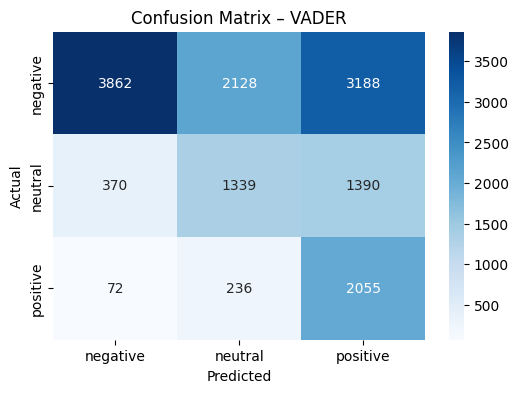

In [18]:
print("\nClassification Report (VADER vs Actual):")
print(classification_report(df['airline_sentiment'], df['VADER_Sentiment']))

cm = confusion_matrix(df['airline_sentiment'], df['VADER_Sentiment'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – VADER")
plt.show()


# 9. Word Cloud (Week 3)

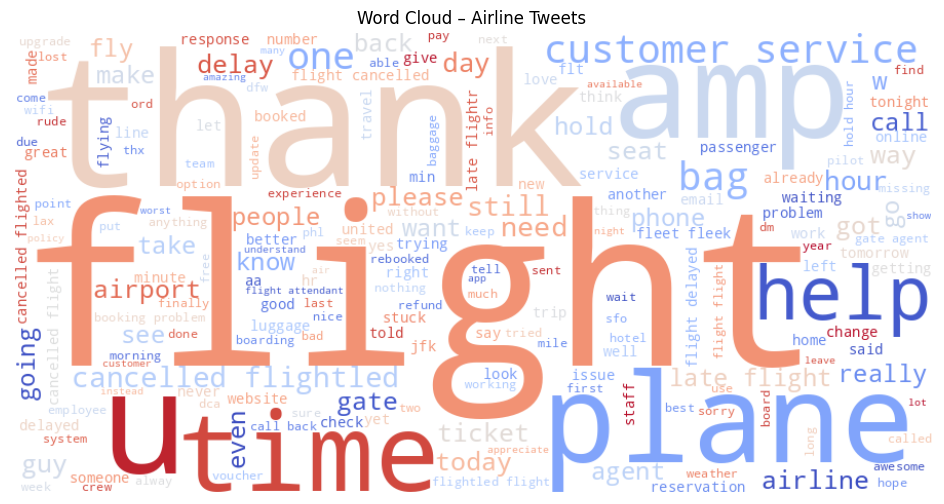

In [19]:
all_words = " ".join(df['clean_text'])

wordcloud = WordCloud(
    width=900,
    height=450,
    background_color='white',
    colormap='coolwarm'
).generate(all_words)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Airline Tweets")
plt.show()


#. 10 Sentiment Distribution by Airline

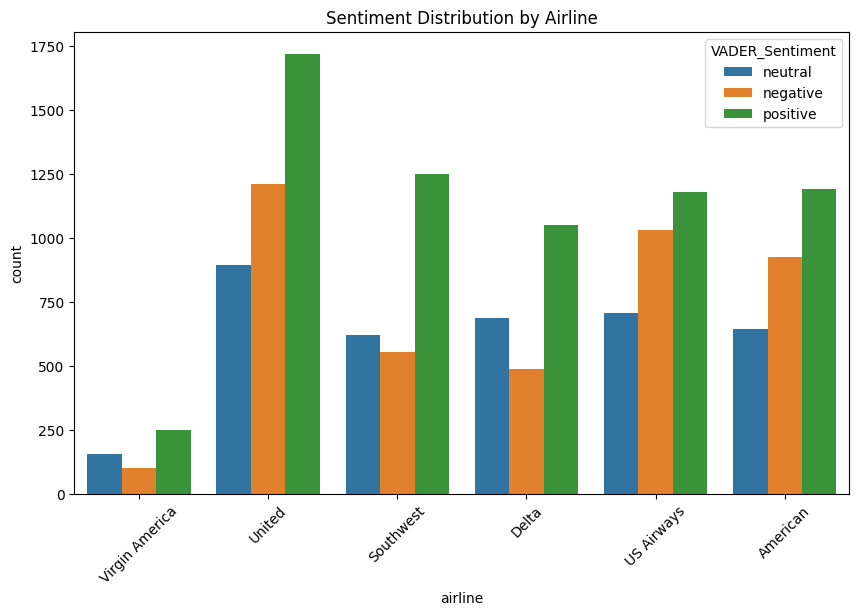

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='airline', hue='VADER_Sentiment')
plt.xticks(rotation=45)
plt.title("Sentiment Distribution by Airline")
plt.show()


# 11. Sentiment Trend Over Time (Week 3)

/tmp/ipython-input-2153873898.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['tweet_created'] = pd.to_datetime(df['tweet_created'])


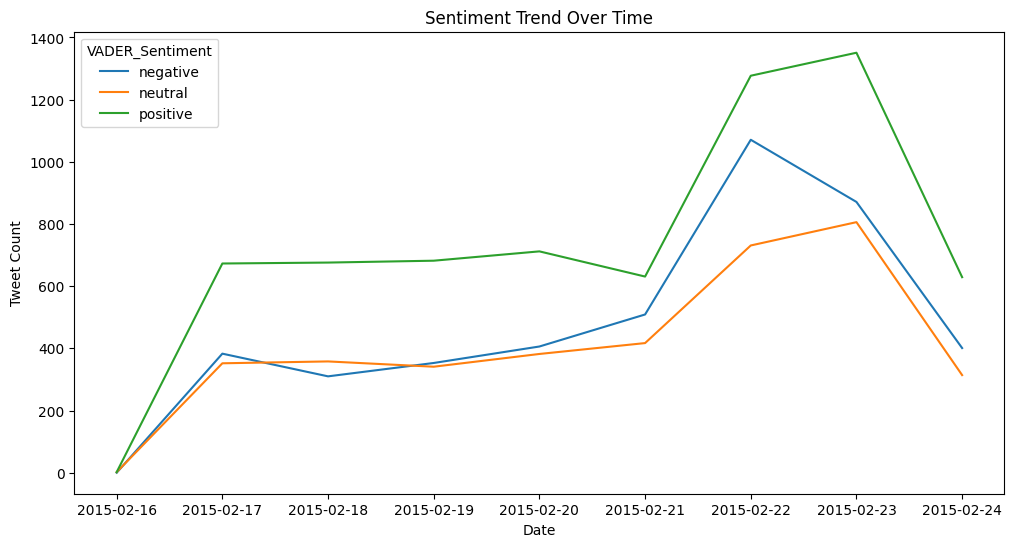

In [22]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

trend = (
    df.groupby(df['tweet_created'].dt.date)['VADER_Sentiment']
    .value_counts()
    .unstack()
    .fillna(0)
)

trend.plot(figsize=(12,6))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.show()


# 12. Sentiment Spike Detection

In [23]:
trend['Total'] = trend.sum(axis=1)
threshold = trend['Total'].mean() + trend['Total'].std()

spikes = trend[trend['Total'] > threshold]
print("High-Activity Sentiment Days:")
print(spikes)


High-Activity Sentiment Days:
VADER_Sentiment  negative  neutral  positive   Total
tweet_created                                       
2015-02-22         1071.0    731.0    1277.0  3079.0
2015-02-23          871.0    806.0    1351.0  3028.0


# **Final Results**

In [25]:
df.to_csv("Final_Airline_Sentiment_Analysis_Report.csv", index=False)
print("Final report saved successfully")


Final report saved successfully
